<a href="https://colab.research.google.com/github/kiprop12/DNSChallenge/blob/master/SoundGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [2]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:
!pip install librosa
!pip install soundfile

**Util methods to handle STFT and creation on the masks**

In [0]:
import soundfile as sf
import librosa
import numpy as np, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa.display
K = 10
C = 0.1
E = 1e-8

def sigmoid(x):
  y = 1 / (1 + np.exp(-x))
  return y

def logistic(y):
  x = np.log(np.divide(y,(1 - y + E)))
  return x

def get_RealImagComponents(compressedSig):
  return np.real(compressedSig), np.imag(compressedSig)

def get_compressedComponents(rCleanSTFT, iCleanSTFT, rNoiseSTFT, iNoiseSTFT):
  old_err_state = np.seterr(divide='raise')
  YrSr =  rNoiseSTFT * rCleanSTFT 
  YiSi = iNoiseSTFT * iCleanSTFT
  YrSi = rNoiseSTFT * iCleanSTFT
  YiSr = iNoiseSTFT * rCleanSTFT
  YrSq_YiSq = np.square(rNoiseSTFT) + np.square(iNoiseSTFT)

  Mreal = np.divide((YrSr + YiSi),YrSq_YiSq + E)
  Mimg = np.divide((YrSi - YiSr), YrSq_YiSq + E)
  crM = -(C * Mreal)
  crM = np.float64(crM)
  expCrm = np.exp(crM)
  cIRMr = (K * (1 - expCrm)/(1 + expCrm + E))

  crM = -(C * Mimg)
  crM = np.float64(crM)
  expCrm = np.exp(crM)
  cIRMi = (K * (1 - expCrm)/(1 + expCrm))

  cIRMr = sigmoid(cIRMr)
  cIRMi = sigmoid(cIRMi)

  return cIRMr, cIRMi

def getUnCompressed(compCIRM):
  divVal = np.divide((K - compCIRM), (K + compCIRM + E))
  divVal = np.float64(divVal)
  unCompCIRM  = (-1/C) * np.log(divVal + E)
  return unCompCIRM

def openFile(filename):
  fileData, sampleRate = sf.read(filename, start=0, stop=None)
  return fileData, sampleRate

def power_law(data,power=0.3):
    # assume input has negative value
    mask = np.zeros(data.shape)
    mask[data>=0] = 1
    mask[data<0] = -1
    data = np.power(np.abs(data),power)
    data = data*mask
    return data

def getSoundSTFT(fileDataName):
  fileData, sampleRate = openFile(fileDataName)
  soundSTFT = librosa.stft(fileData, n_fft=512, hop_length=32)
  soundSTFT = soundSTFT.transpose()
  return soundSTFT

def getCompressedCIRM(cleanDataFile, noisyDataFile):
  cleanSTFT = getSoundSTFT(cleanDataFile)
  noiseSTFT = getSoundSTFT(noisyDataFile)
  realCleanSTFT, imgCleanSTFT = get_RealImagComponents(cleanSTFT)
  realNoiseSTFT, imgNoiseSTFT = get_RealImagComponents(noiseSTFT)
  cIRMr, cIRMi = get_compressedComponents(realCleanSTFT, imgCleanSTFT, realNoiseSTFT, imgNoiseSTFT)
  return cIRMr, cIRMi

**Generator Class**

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import os


class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, filePath, list_IDs, Xdim=(5001, 257, 2), ydim=(5001, 257, 2), batch_size=1, shuffle=True):
        'Initialization'
        self.list_IDs = list_IDs
        self.cleanFilesNames = os.listdir(filePath + '/clean')
        self.noisyFilesNames = os.listdir(filePath + '/noisy') 
        self.cleanFileDict = self.createFileDict(self.cleanFilesNames)
        self.noisyFileDict = self.createFileDict(self.noisyFilesNames)
        self.Xdim = Xdim
        self.ydim = ydim
        self.batch_size = batch_size
        self.filePath = filePath

        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def getitem__(self, index):
      X, y = self.__getitem__(index)

      return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.Xdim))
        y = np.empty((self.batch_size, *self.ydim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
          index = ID.find('fileid_')
          fileSearchStr = ID[index:]
          noiseFilePath = self.filePath + '/noisy/' + self.noisyFileDict.get(fileSearchStr)
          cleanFilePath = self.filePath + '/clean/' + self.cleanFileDict.get(fileSearchStr)
          # Store sample
          complexNoiseSTFT = getSoundSTFT(noiseFilePath)
          realNoiseSTFT, imgNoiseSTFT = get_RealImagComponents(complexNoiseSTFT)
          X[i, :, :, 0] = realNoiseSTFT
          X[i, :, :, 1] = imgNoiseSTFT
          #X[i, :, :, 0] = imgNoiseSTFT

          # Store class
          cIRMr, cIRMi = getCompressedCIRM(cleanFilePath, noiseFilePath)
          y[i, :, :, 0] = cIRMr
          y[i, :, :, 1] = cIRMi
          #y[i, :, :, 0] = cIRMi

        return X, y

    def createFileDict(self, fileDirList):
      fileDict = {}
      for fileName in fileDirList:
        fileStr = str(fileName)
        index = fileStr.find('fileid_')
        fileStr = fileStr[index:]
        fileDict[fileStr] = fileName
      return fileDict

**The Model to predict the mask**

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, BatchNormalization, TimeDistributed, \
                         Reshape, Bidirectional, LSTM, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
numChannels = 2
numBins = 257
numTimeSlots = 5001

input_shape=(numTimeSlots, numBins, numChannels)

model.add(Conv2D(32, kernel_size=(1, 7), strides=(1, 1), input_shape=input_shape, padding='same', dilation_rate=(1, 1), name='conv1'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(7, 1), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv2'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv3'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(2, 1), name='conv4'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(4, 1), name='conv5'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(8, 1), name='conv6'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(16, 1), name='conv7'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(32, 1), name='conv8'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv9'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(2, 2), name='conv10'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(4, 4), name='conv11'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(8, 8), name='conv12'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(16, 16), name='conv13'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(32, 32), name='conv14'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

model.add(Conv2D(8, kernel_size=(1, 1), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv15'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(400,input_shape=(5001,8*257),return_sequences=True),merge_mode='sum'))

model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model.add(Dense(600, name="fc2", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=42)))
model.add(Dense(600, name="fc3", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=65)))
model.add(Dense(numBins * numChannels,  activation='sigmoid', name="complex_mask", kernel_initializer=tf.keras.initializers.glorot_uniform(seed=87)))

model.add(Reshape((numTimeSlots, numBins, numChannels)))


Opt = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=Opt)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 5001, 257, 32)     480       
_________________________________________________________________
batch_normalization (BatchNo (None, 5001, 257, 32)     128       
_________________________________________________________________
activation (Activation)      (None, 5001, 257, 32)     0         
_________________________________________________________________
conv2 (Conv2D)               (None, 5001, 257, 32)     7200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5001, 257, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 5001, 257, 32)     0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5001, 257, 32)     2

**Train the Model**

In [0]:
from keras.models import Sequential, model_from_json
from keras import optimizers
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, Bidirectional,TimeDistributed
from keras.layers import Dropout, Flatten, BatchNormalization, ReLU, Reshape, Permute
from keras.layers.core import Activation
from keras.layers.merge import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from keras.models import Model, load_model
from keras.initializers import he_normal, glorot_uniform

RESTORE = False

def scheduler(epoch):
  ini_lr = 0.001
  lr = ini_lr
  if epoch >= 60:
    lr = ini_lr / 5
  if epoch >= 100:
    lr = ini_lr / 10
  #lr = ini_lr
  return lr

def latest_file(dir):
    lists = os.listdir(dir)
    lists.sort(key=lambda fn: os.path.getmtime(dir + fn))
    file_latest = os.path.join(dir, lists[-1])
    return file_latest

rlr = LearningRateScheduler(scheduler, verbose=1)
savedModelsPath = './drive/My Drive/saved_models'
folder = os.path.exists(savedModelsPath)
if not folder:
  os.makedirs(savedModelsPath)
  print('create folder to save models')
filepath = savedModelsPath + "/Model-" + "-{epoch:03d}-{val_loss:.10f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=5)

batch_size = 1
epochs = 300
initial_epoch = 0
if RESTORE:
        last_file = latest_file('./drive/My Drive/saved_models/')
        print(last_file)
        model.load_weights(last_file)
        info = last_file.strip().split('-')
        initial_epoch = int(info[-2])
        print(initial_epoch)


baseFilePath = './drive/My Drive/Data/KipBERT/SoundData/synthetic/no_reverb'
cleanFilesNames = os.listdir(baseFilePath + '/clean')
trainFileNames =  cleanFilesNames[0:120] #cleanFilesNames[0:1]
validationFileNames = cleanFilesNames[120:] #cleanFilesNames[0:1] 
training_generator = DataGenerator(baseFilePath, trainFileNames, batch_size=batch_size, shuffle=True)
validation_generator = DataGenerator(baseFilePath, validationFileNames, batch_size=batch_size, shuffle=True)
hist = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    callbacks=[checkpoint, rlr],
                    initial_epoch=initial_epoch)

Using TensorFlow backend.


Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/300
120/120 [==============================] - 186s 2s/step - loss: 0.0040 - val_loss: 0.0041 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/300
120/120 [==============================] - 170s 1s/step - loss: 0.0036 - val_loss: 0.0037 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/300
120/120 [==============================] - 170s 1s/step - loss: 0.0034 - val_loss: 0.0036 - lr: 0.0010

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/300
120/120 [==============================] - 170s 1s/step - loss: 0.0034 - val_loss: 0.0032 - lr: 0.0010

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/300
120/120 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00005: val_loss improved from inf t

In [0]:
#model.save('./drive/My Drive/Data/KipBERT/savedModel_lr-001-0002-0001_kernel-32_model-deep_params-9450306-10000Epochs-150Samples.h5')
#model.load_weights('./drive/My Drive/Data/KipBERT/savedModel.h5')

**Run prediction**

In [0]:
def getSingleFileNameList(index):
  #predictFileNames = trainFileNames[index:index+1]
  predictFileNames = validationFileNames[index:index+1]
  return predictFileNames

def getFileID(fileName):
  index = fileName.find('fileid_')
  fileStr = fileName[index:]
  return fileStr

In [0]:
predictFileNames = getSingleFileNameList(0)
print(predictFileNames)
predict_generator = DataGenerator(baseFilePath, predictFileNames, batch_size=1, shuffle=False)
predictedMask = model.predict(x=predict_generator)
print(predictedMask.shape)
noisyFFT, cirm = predict_generator.getitem__(0)

['clean_fileid_0.wav']
(1, 5001, 257, 2)


In [0]:
print(cirm[0, :, :, 0].min(), cirm[0, :, :, 0].max(), cirm[0, :, :, 0].mean())
print(predictedMask[0, :, :, 0].min(), predictedMask[0, :, :, 0].max(), predictedMask[0, :, :, 0].mean())
print("cirm and predicted mask shape: ", cirm.shape, predictedMask.shape)
print(cirm[0, 5000, 256, 0])
print(predictedMask[0, 5000, 256, 0])
print(predictedMask[0, 5000, 256, 0])

4.5397868703378437e-05 0.9999544084273436 0.6066449627679906
0.020992547 0.97828853 0.60685575
cirm and predicted mask shape:  (1, 5001, 257, 2) (1, 5001, 257, 2)
0.6109499209960033
0.65013325
0.65013325


In [0]:
lossTensor = tf.keras.losses.mean_squared_error(cirm, predictedMask)
print(lossTensor.shape)
print(np.max(lossTensor), np.min(lossTensor))
print(np.sum(lossTensor)/(5001*257))
log_cIRMr = logistic(cirm[0, :, :, 0])
log_cIRMi = logistic(cirm[0, :, :, 1])
log_predictedMaskr = logistic(predictedMask[0, :, :, 0])
log_predictedMaski = logistic(predictedMask[0, :, :, 1])
print("cirm_real: ", log_cIRMr.min(), log_cIRMr.max(), log_cIRMr.mean(), np.median(log_cIRMr))
print("cirm_img: ", log_cIRMi.min(), log_cIRMi.max(), log_cIRMi.mean(), np.median(log_cIRMi))
print("predictedMask_real: ", log_predictedMaskr.min(), log_predictedMaskr.max(),
      log_predictedMaskr.mean(), np.median(log_predictedMaskr))
print("predictedMask_img: ", log_predictedMaski.min(), log_predictedMaski.max(),
      log_predictedMaski.mean(), np.median(log_predictedMaski))

(1, 5001, 257)
0.25037962 3.1636915e-12
0.00030383664800964907
cirm_real:  -10.000000009979658 9.99552276134818 0.4362020177576591 0.49771791066456655
cirm_img:  -9.985431374930462 9.999779748749022 2.8818007512772435e-05 -1.9999999856405972e-08
predictedMask_real:  -3.8423717 3.8079636 0.4365713 0.49272072
predictedMask_img:  -2.631667 3.7581887 -0.00016607605 4.029193e-05


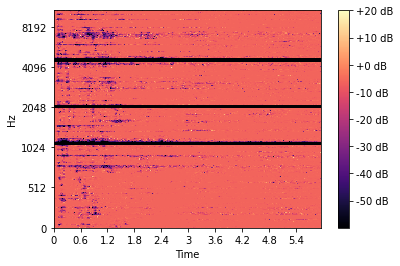

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(log_cIRMr), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')

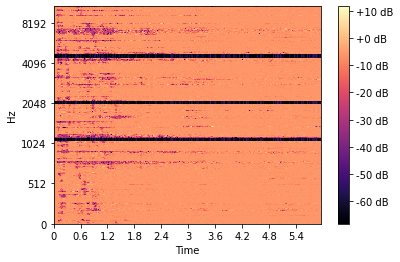

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(log_predictedMaskr), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [0]:

unCompCIRMr = getUnCompressed(log_predictedMaskr)
unCompCIRMi = getUnCompressed(log_predictedMaski)
realNoiseSTFT = noisyFFT[0, :, :, 0]
imgNoiseSTFT = noisyFFT[0, :, :, 1]
unCompCIRM = unCompCIRMr + 1j*unCompCIRMi
noiseSTFT = realNoiseSTFT + 1j*imgNoiseSTFT
separatedSTFT = noiseSTFT * unCompCIRM
separatedSTFT = separatedSTFT.transpose()
separateAudio = librosa.istft(separatedSTFT,32, 512)
sf.write('./drive/My Drive/Data/KipBERT/Separated_' + getFileID(predictFileNames[0]), separateAudio, 16000)

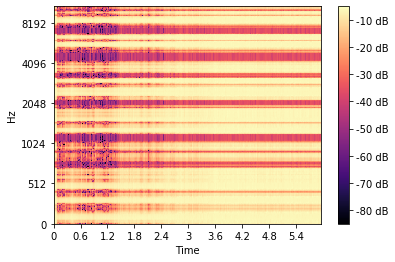

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(log_predictedMaskr), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(log_predictedMask), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')

NameError: ignored

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(log_predictedMask), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')

NameError: ignored

bidirectional = ave plus lr = 0.001 epochs = 100 with sigmoid

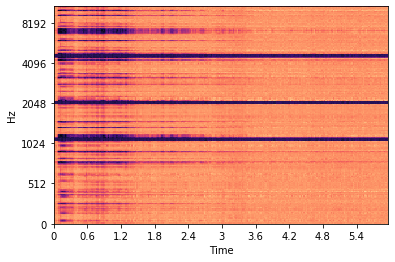

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(predictedMask[0, :, :, 0]), y_axis='mel', x_axis='time')

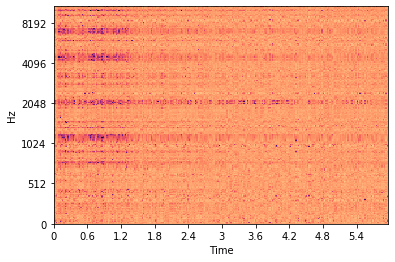

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(predictedMask[0, :, :, 0]), y_axis='mel', x_axis='time')

bidirectional = ave plus lr = 0.001 epochs = 100

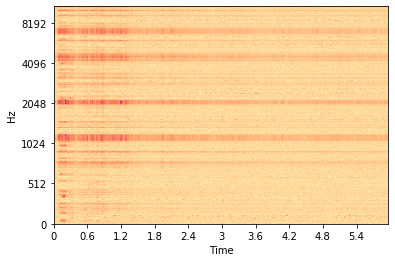

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(predictedMask[0, :, :, 0]), y_axis='mel', x_axis='time')

bidirectional = ave plus lr = 0.0001 epochs = 500

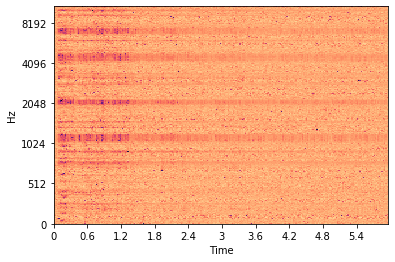

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(predictedMask[0, :, :, 0]), y_axis='mel', x_axis='time')

bidirectional = Sum plus lr = 0.0001 epochs = 500

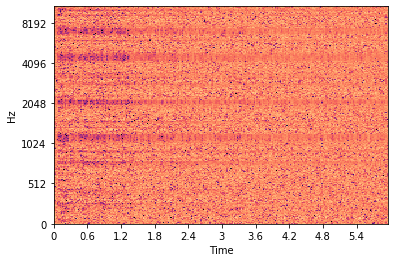

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(predictedMask[0, :, :, 0]), y_axis='mel', x_axis='time')

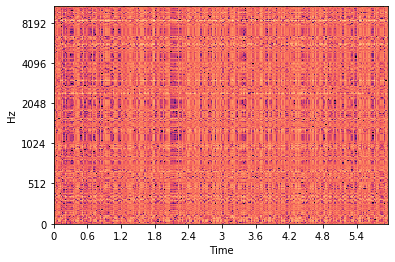

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(predictedMask[0, :, :, 0]), y_axis='mel', x_axis='time')

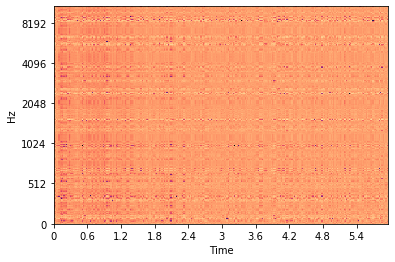

In [0]:
librosa.display.specshow(librosa.amplitude_to_db(predictedMask[0, :, :, 0]), y_axis='mel', x_axis='time')

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, BatchNormalization, TimeDistributed, \
                         Reshape, Bidirectional, LSTM
#from tensorflow.keras.layers.recurrent import LSTM
from tensorflow.keras.models import Sequential

model = Sequential()
numChannels = 2
numBins = 257
numTimeSlots = 501

input_shape=(numTimeSlots, numBins, numChannels)

model.add(Conv2D(32, (3, 3), strides=(1, 1), input_shape=input_shape, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(8, (3, 3), strides=(1, 1), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(TimeDistributed(Flatten()))
#model.add(Dropout(rate=0.25))

#model.add(Bidirectional(LSTM(400,input_shape=(298,8*257),return_sequences=True),merge_mode='sum'))

model.add(Dense(600, name="fc1", activation='relu'))#, kernel_initializer=tf.keras.initializers.he_normal(seed=27)))

model.add(Dense(600, name="fc2", activation='relu'))#, kernel_initializer=tf.keras.initializers.he_normal(seed=42)))

model.add(Dense(600, name="fc3", activation='relu'))#, kernel_initializer=tf.keras.initializers.he_normal(seed=65)))

model.add(Dense(numBins * numChannels , name="complex_mask"))#, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=87)))

model.add(Reshape((numTimeSlots, numBins, numChannels)))


Opt = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=Opt)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 501, 257, 32)      608       
_________________________________________________________________
batch_normalization_3 (Batch (None, 501, 257, 32)      128       
_________________________________________________________________
activation_3 (Activation)    (None, 501, 257, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 501, 257, 32)      9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 501, 257, 32)      128       
_________________________________________________________________
activation_4 (Activation)    (None, 501, 257, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 501, 257, 8)      

**Test the generator**

In [0]:
baseFilePath = './drive/My Drive/Data/KipBERT/SoundData/synthetic/no_reverb'
cleanFilesNames = os.listdir(baseFilePath + '/clean')
trainFileNames = cleanFilesNames[0:120]
validationFileNames = cleanFilesNames[120:]
print("Length of trainFileNames: ", len(trainFileNames))
print(trainFileNames)
print("Length of validationFileNames: ", len(validationFileNames))
print(validationFileNames)
train_generator = DataGenerator(baseFilePath, trainFileNames, batch_size=2, shuffle=True)
noisyFFT, cirm = train_generator.getitem__(0)
print(noisyFFT.shape, cirm.shape)
print(noisyFFT[0][1000][200][0])
print(noisyFFT[0][1000][200][1])

Length of trainFileNames:  120
['clean_fileid_0.wav', 'clean_fileid_110.wav', 'clean_fileid_104.wav', 'clean_fileid_102.wav', 'clean_fileid_105.wav', 'clean_fileid_107.wav', 'clean_fileid_101.wav', 'clean_fileid_113.wav', 'clean_fileid_116.wav', 'clean_fileid_112.wav', 'clean_fileid_117.wav', 'clean_fileid_134.wav', 'clean_fileid_118.wav', 'clean_fileid_132.wav', 'clean_fileid_125.wav', 'clean_fileid_133.wav', 'clean_fileid_130.wav', 'clean_fileid_127.wav', 'clean_fileid_137.wav', 'clean_fileid_136.wav', 'clean_fileid_139.wav', 'clean_fileid_149.wav', 'clean_fileid_145.wav', 'clean_fileid_146.wav', 'clean_fileid_143.wav', 'clean_fileid_142.wav', 'clean_fileid_14.wav', 'clean_fileid_147.wav', 'clean_fileid_150.wav', 'clean_fileid_152.wav', 'clean_fileid_155.wav', 'clean_fileid_158.wav', 'clean_fileid_156.wav', 'clean_fileid_16.wav', 'clean_fileid_161.wav', 'clean_fileid_163.wav', 'clean_fileid_165.wav', 'clean_fileid_167.wav', 'clean_fileid_169.wav', 'clean_fileid_166.wav', 'clean_filei

In [0]:
sf.read("./drive/My Drive/Data/KipBERT/SoundData/synthetic/no_reverb/clean/clean_fileid_101.wav", start= 0, stop=None)

(array([-0.00045776,  0.        ,  0.0005188 , ..., -0.00018311,
        -0.00033569, -0.00027466]), 16000)

In [0]:
predictFileNames = getSingleFileNameList(0)
print(predictFileNames)
predict_generator = DataGenerator(baseFilePath, predictFileNames, batch_size=1, shuffle=False)
noisyFFT, cirm = predict_generator.getitem__(0)
print(noisyFFT.shape)
print(cirm.shape)

['clean_fileid_0.wav']
(1, 5001, 257, 2)
(1, 5001, 257, 2)


**Getting filtered audio from the mask multiplied by noisy STFT**

In [0]:
unCompCIRMr = getUnCompressed(cirm[0, :, :, 0])
unCompCIRMi = getUnCompressed(cirm[0, :, :, 1])
realNoiseSTFT = noisyFFT[0, :, :, 0]
imgNoiseSTFT = noisyFFT[0, :, :, 1]
unCompCIRM = unCompCIRMr + 1j*unCompCIRMi
noiseSTFT = realNoiseSTFT + 1j*imgNoiseSTFT
separatedSTFT = noiseSTFT * unCompCIRM
separatedSTFT = separatedSTFT.transpose()
separateAudio = librosa.istft(separatedSTFT,32, 512)
sf.write('./drive/My Drive/Data/KipBERT/Separated_fileid_245.wav', separateAudio, 16000)


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, BatchNormalization, TimeDistributed, \
                         Reshape, Bidirectional, LSTM, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
numChannels = 2
numBins = 257
numTimeSlots = 5001

input_shape=(numTimeSlots, numBins, numChannels)

model.add(Conv2D(32, kernel_size=(1, 7), strides=(1, 1), input_shape=input_shape, padding='same', dilation_rate=(1, 1), name='conv1'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(7, 1), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv2'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv3'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(2, 1), name='conv4'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(4, 1), name='conv5'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(8, 1), name='conv6'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(16, 1), name='conv7'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(32, 1), name='conv8'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv9'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(2, 2), name='conv10'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(4, 4), name='conv11'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(8, 8), name='conv12'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(16, 16), name='conv13'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same', dilation_rate=(32, 32), name='conv14'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

model.add(Conv2D(8, kernel_size=(1, 1), strides=(1, 1), padding='same', dilation_rate=(1, 1), name='conv15'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(400,input_shape=(5001,8*257),return_sequences=True),merge_mode='sum'))

model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model.add(Dense(600, name="fc2", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=42)))
model.add(Dense(600, name="fc3", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=65)))
model.add(Dense(numBins * numChannels,  activation='sigmoid', name="complex_mask", kernel_initializer=tf.keras.initializers.glorot_uniform(seed=87)))

model.add(Reshape((numTimeSlots, numBins, numChannels)))


Opt = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=Opt)

model.summary()

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, BatchNormalization, TimeDistributed, \
                         Reshape, Bidirectional, LSTM, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
numChannels = 2
numBins = 257
numTimeSlots = 5001

input_shape=(numTimeSlots, numBins, numChannels)

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, input_shape=input_shape, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
#model.add(MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding="same"))

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
#model.add(MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding="same"))


model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(400,input_shape=(5001,32*257),return_sequences=True),merge_mode='ave'))

#model.add(Dense(numBins * numChannels , name="complex_mask", kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.5, maxval= 0.5, seed=27)))
#model.add(Dense(600, name="fc1", kernel_initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=27)))
#model.add(LeakyReLU())
#model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.Constant(value=1.0)))
model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model.add(Dense(600, name="fc2", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=42)))
#model.add(LeakyReLU())
model.add(Dense(600, name="fc3", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=65)))
#model.add(Dense(256, name="fc1", kernel_initializer='random_uniform'))
#model.add(LeakyReLU())

model.add(Dense(numBins * numChannels, activation='sigmoid' ,name="complex_mask", kernel_initializer=tf.keras.initializers.glorot_uniform(seed=87)))

model.add(Reshape((numTimeSlots, numBins, numChannels)))


Opt = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=Opt)
#model.compile(loss='mean_absolute_error', optimizer=Opt)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5001, 257, 32)     1632      
_________________________________________________________________
batch_normalization (BatchNo (None, 5001, 257, 32)     128       
_________________________________________________________________
activation (Activation)      (None, 5001, 257, 32)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5001, 257, 32)     25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5001, 257, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 5001, 257, 32)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5001, 257, 32)     2

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, BatchNormalization, TimeDistributed, \
                         Reshape, Bidirectional, LSTM, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
numChannels = 2
numBins = 257
numTimeSlots = 5001

input_shape=(numTimeSlots, numBins, numChannels)

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation=None, input_shape=input_shape, padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation=None, padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
#model.add(MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding="same"))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation=None, padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation=None, padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
#model.add(MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding="same"))


model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(400,input_shape=(5001,32*257),return_sequences=True),merge_mode='ave'))

#model.add(Dense(numBins * numChannels , name="complex_mask", kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.5, maxval= 0.5, seed=27)))
#model.add(Dense(600, name="fc1", kernel_initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=27)))
#model.add(LeakyReLU())
#model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.Constant(value=1.0)))
model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model.add(Dense(600, name="fc2", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=42)))
#model.add(LeakyReLU())
model.add(Dense(600, name="fc3", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=65)))
#model.add(Dense(256, name="fc1", kernel_initializer='random_uniform'))
#model.add(LeakyReLU())

model.add(Dense(numBins * numChannels, activation='sigmoid' ,name="complex_mask", kernel_initializer=tf.keras.initializers.glorot_uniform(seed=87)))

model.add(Reshape((numTimeSlots, numBins, numChannels)))


Opt = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=Opt)
#model.compile(loss='mean_absolute_error', optimizer=Opt)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 4999, 255, 32)     608       
_________________________________________________________________
batch_normalization_12 (Batc (None, 4999, 255, 32)     128       
_________________________________________________________________
activation_12 (Activation)   (None, 4999, 255, 32)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4997, 253, 32)     9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 4997, 253, 32)     128       
_________________________________________________________________
activation_13 (Activation)   (None, 4997, 253, 32)     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4995, 251, 32)    

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, BatchNormalization, TimeDistributed, \
                         Reshape, Bidirectional, LSTM, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
numChannels = 2
numBins = 257
numTimeSlots = 5001

input_shape=(numTimeSlots, numBins, numChannels)

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, input_shape=input_shape, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
#model.add(MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding="same"))

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
model.add(Conv2D(32, (5, 5), strides=(1, 1), activation=None, padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(LeakyReLU())
#model.add(MaxPooling2D(pool_size=(3,3), strides=(1, 1), padding="same"))


model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(400,input_shape=(5001,32*257),return_sequences=True),merge_mode='ave'))

#model.add(Dense(numBins * numChannels , name="complex_mask", kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.5, maxval= 0.5, seed=27)))
#model.add(Dense(600, name="fc1", kernel_initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=1.0, seed=27)))
#model.add(LeakyReLU())
#model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.Constant(value=1.0)))
model.add(Dense(600, name="fc1", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=27)))
model.add(Dense(600, name="fc2", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=42)))
#model.add(LeakyReLU())
model.add(Dense(600, name="fc3", activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=65)))
#model.add(Dense(256, name="fc1", kernel_initializer='random_uniform'))
#model.add(LeakyReLU())

model.add(Dense(numBins * numChannels, activation='sigmoid' ,name="complex_mask", kernel_initializer=tf.keras.initializers.glorot_uniform(seed=87)))

model.add(Reshape((numTimeSlots, numBins, numChannels)))


Opt = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=Opt)
#model.compile(loss='mean_absolute_error', optimizer=Opt)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5001, 257, 32)     1632      
_________________________________________________________________
batch_normalization (BatchNo (None, 5001, 257, 32)     128       
_________________________________________________________________
activation (Activation)      (None, 5001, 257, 32)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5001, 257, 32)     25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5001, 257, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 5001, 257, 32)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5001, 257, 32)     2

In [0]:
# sf.__version__
import soundfile as sf
sf.__version__

'0.10.3'